In [26]:
import numpy as np
import matplotlib.pyplot as plt
import math

plt.rcParams['axes.linewidth'] = 3.0

electron_charge = -4.8e-10 # in statC

In [27]:
coords_array = np.loadtxt('particles.dat')

In [28]:
def solve_poisson_relax(particle_array,M,tol):

    phi_grid = np.zeros([M+1,M+1],float)    # note that the indices here are to be interpreted as [x,y]
    phiprime_grid = np.zeros([M+1,M+1],float)
    a = 1   # this is the grid spacing, it is in cm
    
    # calculate the charge distribution
    rho_grid = make_rhogrid(particle_array=particle_array,M=M,charge=electron_charge)

    delta = 100
    iterations=0
    
    while delta > tol:
        iterations+=1
        # calculate new potential values
        for i in range(M+1):
            for j in range(M+1):
                if i == 0 or i == M or j == 0 or j == M:
                    phiprime_grid[i,j] = phi_grid[i,j]
                else:
                    phiprime_grid[i,j] = (1/4) * (phi_grid[i+1,j] + phi_grid[i-1,j] + phi_grid[i,j+1] + phi_grid[i,j-1] + (4*np.pi * a**2) *rho_grid[i,j])
        delta = np.max(np.abs(phi_grid-phiprime_grid))
        phi_grid,phiprime_grid = phiprime_grid,phi_grid
    
    return phi_grid,iterations


def solve_poisson_gs(particle_array,M,tol,omega):

    phi_grid = np.zeros([M+1,M+1],float)    # note that the indices here are to be interpreted as [x,y]
    a = 1   # this is the grid spacing, it is in cm
    
    # calculate the charge distribution
    rho_grid = make_rhogrid(particle_array=particle_array,M=M,charge=electron_charge)

    delta = 100
    iterations=0
    
    while delta > tol:
        iterations+=1
        # calculate new potential values
        og_phi = phi_grid.copy()
        for i in range(M+1):
            for j in range(M+1):
                if i == 0 or i == M or j == 0 or j == M:
                    phi_grid[i,j] = phi_grid[i,j]
                else:
                    phi_grid[i,j] = ((1+omega)/4) * (phi_grid[i+1,j] + phi_grid[i-1,j] + phi_grid[i,j+1] + phi_grid[i,j-1] + (4*np.pi * a**2) *rho_grid[i,j]) - omega*phi_grid[i,j]
        delta = np.max(np.abs(phi_grid-og_phi))
    
    return phi_grid,iterations

def make_rhogrid(particle_array,M,charge):
    grid = np.zeros([M+1, M+1],float)
    charges = charge*np.ones(len(particle_array))
    x=particle_array[:,0]
    y=particle_array[:,1]

    # (x0,y0) and (x1,y1) are the bottom left and top right grid points of the cell corresponding to each particle; for example if (x,y) = (5.5,6.4), (x0,y0) = (5,6), (x1,y1) = (6,7)
    x0 = x.astype(int)
    y0 = y.astype(int)
    x1 = x0 + 1
    y1 = y0 + 1

    # These are the distances from each paricle to the bottom left of the cell it is in
    dx = x - x0
    dy = y - y0

    # weighted charge contributions; these say how close each particle is to the four corners of the cell it is in (00 bottom left, 10 bottom right, 01 top left, 11 top right)
    q00 = (1 - dx) * (1 - dy) * charges
    q10 = dx       * (1 - dy) * charges
    q01 = (1 - dx) * dy       * charges
    q11 = dx       * dy       * charges

    # this part takes all of the coordinates of the particles and assigns the amount of charge they contribute to each gridpoint to an array with the index at the gridpoint.
    np.add.at(grid, (x0, y0), q00)
    np.add.at(grid, (x1, y0), q10)
    np.add.at(grid, (x0, y1), q01)
    np.add.at(grid, (x1, y1), q11)

    cell_area = 1   # this is because we have set a=1; the area is a^2, and has units of cm^2

    return grid/cell_area

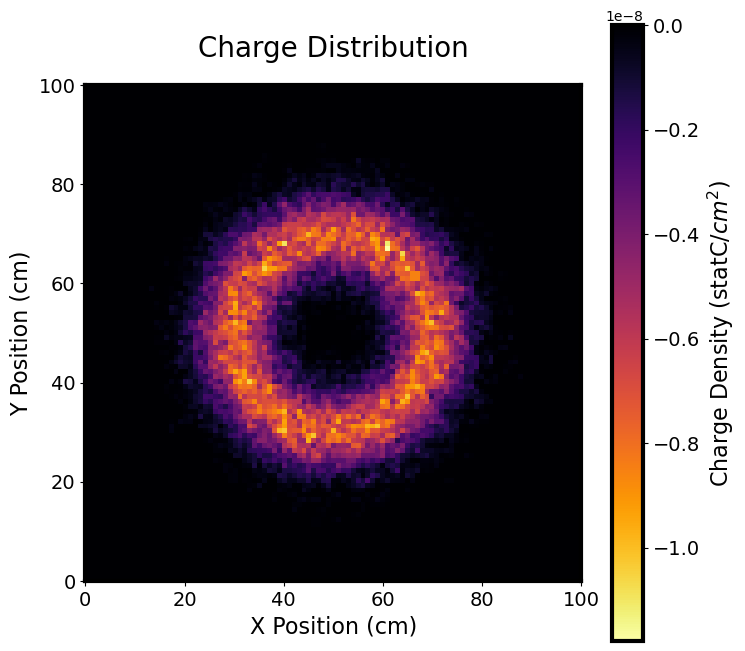

In [33]:
# I will work in gaussian units! So, epsilon_0 is equal to 1/4pi, the electron charge is in statC, and the grid spacing is 1 cm (size 100 cm)
M = 100 # in cm

charge_config = make_rhogrid(particle_array=coords_array,M=M,charge=electron_charge)

plt.figure(figsize=(8, 8))
plt.imshow(charge_config.T, origin='lower', cmap='inferno_r', interpolation='nearest',
           extent=[0, M, 0, M])
plt.title(f'Charge Distribution',fontsize=20,pad=20)
plt.xlabel('X Position (cm)', fontsize=16)
plt.ylabel('Y Position (cm)', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
cbar = plt.colorbar()
cbar.set_label(r'Charge Density (statC/$cm^2$)', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.savefig(f'./hw5_p2_initial_rho',bbox_inches="tight")
plt.show()

In [30]:
phi_grid,n_iter=solve_poisson_relax(coords_array,M=M,tol=1e-10)
print(n_iter)

9626


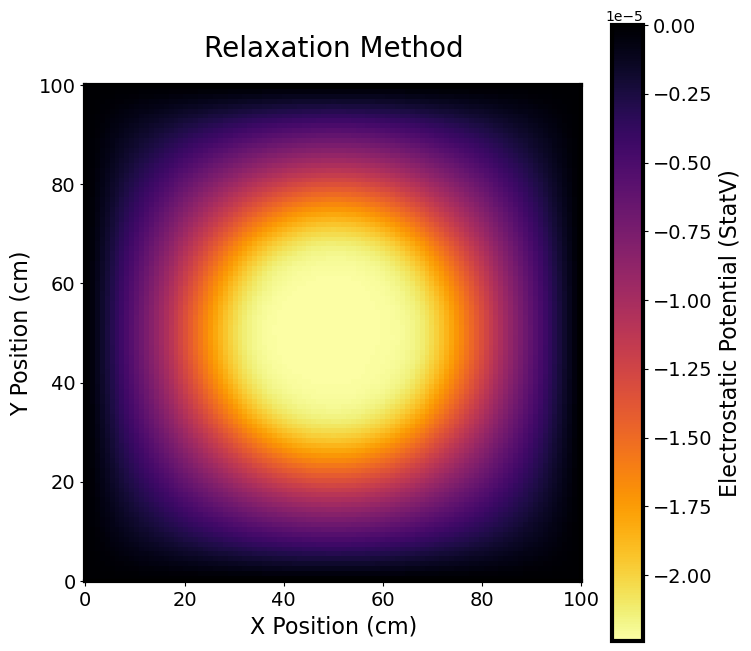

In [34]:
plt.figure(figsize=(8, 8))
plt.imshow(phi_grid.T, origin='lower', cmap='inferno_r', interpolation='nearest',
           extent=[0, M, 0, M])
plt.title(f'Relaxation Method',fontsize=20,pad=20)
plt.xlabel('X Position (cm)', fontsize=16)
plt.ylabel('Y Position (cm)', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
cbar = plt.colorbar()
cbar.set_label(r'Electrostatic Potential (StatV)', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.savefig(f'./hw5_p2_phi_relax',bbox_inches="tight")
plt.show()

In [35]:
omega_opt = 0.9427190999915878 # we calculate this later in the code

phi_grid,n_iter=solve_poisson_gs(coords_array,M=M,tol=1e-10,omega=omega_opt)
print(n_iter)

201


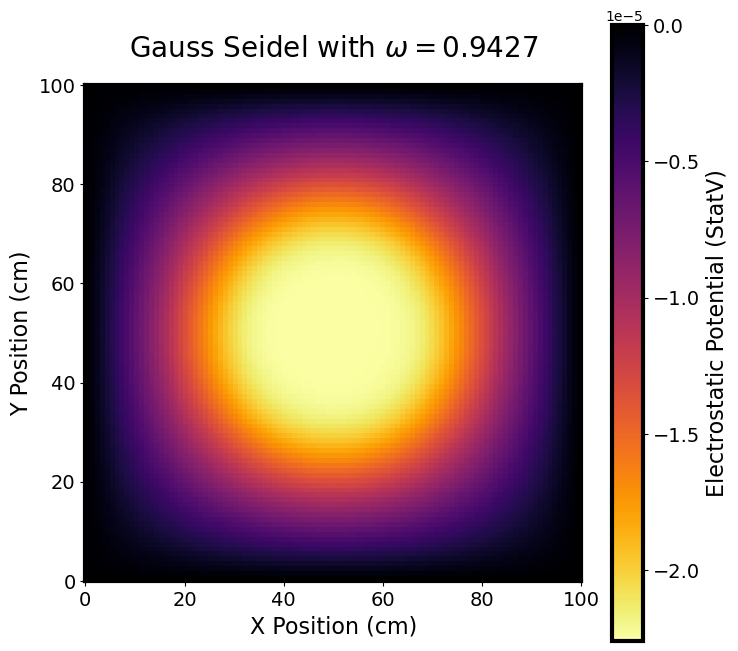

In [36]:
plt.figure(figsize=(8, 8))
plt.imshow(phi_grid.T, origin='lower', cmap='inferno_r', interpolation='nearest',
           extent=[0, M, 0, M])
plt.title(r'Gauss Seidel with $\omega = $' + f'{round(omega_opt,4)}',fontsize=20,pad=20)
plt.xlabel('X Position (cm)', fontsize=16)
plt.ylabel('Y Position (cm)', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
cbar = plt.colorbar()
cbar.set_label(r'Electrostatic Potential (StatV)', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.savefig(f'./hw5_p2_phi_gauss_seidel',bbox_inches="tight")
plt.show()

In [37]:
def golden_ratio_search(f, a, b, tol=1e-3):
    golden_ratio = (math.sqrt(5) - 1) / 2
    
    c = b - golden_ratio * (b - a)
    d = a + golden_ratio * (b - a)
    fc = f(c)
    fd = f(d)
    
    omega_list = np.array([])
    iter_list = np.array([])
    steps = 0
    
    while abs(b - a) > tol:
        steps += 1
        
        if fc < fd:
            omega_list = np.append(omega_list,d) 
            iter_list = np.append(iter_list,fd) 
            b = d
            d = c
            fd = fc
            c = b - golden_ratio * (b - a)
            fc = f(c)
        else:
            omega_list = np.append(omega_list,c) 
            iter_list = np.append(iter_list,fc) 
            a = c
            c = d
            fc = fd
            d = a + golden_ratio * (b - a)
            fd = f(d)
    

    return ((b + a) / 2),steps,omega_list,iter_list

def gs_iter(omega):
    phi_golden_ratioid,n_iter=solve_poisson_gs(coords_array,M=M,tol=1e-10,omega=omega)
    return n_iter

In [38]:
omega_optimal, steps, omega_array, n_iter_array=golden_ratio_search(gs_iter,a=0,b=1,tol=1e-3)

In [39]:
print(omega_optimal)
print(np.min(n_iter_array))

0.9427190999915878
201.0


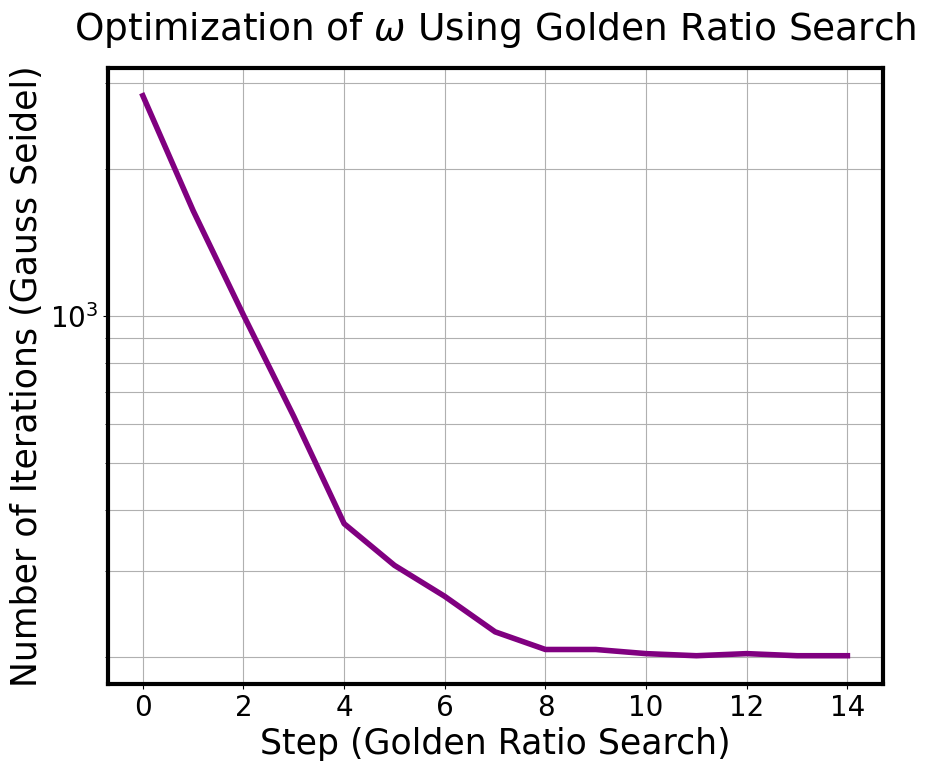

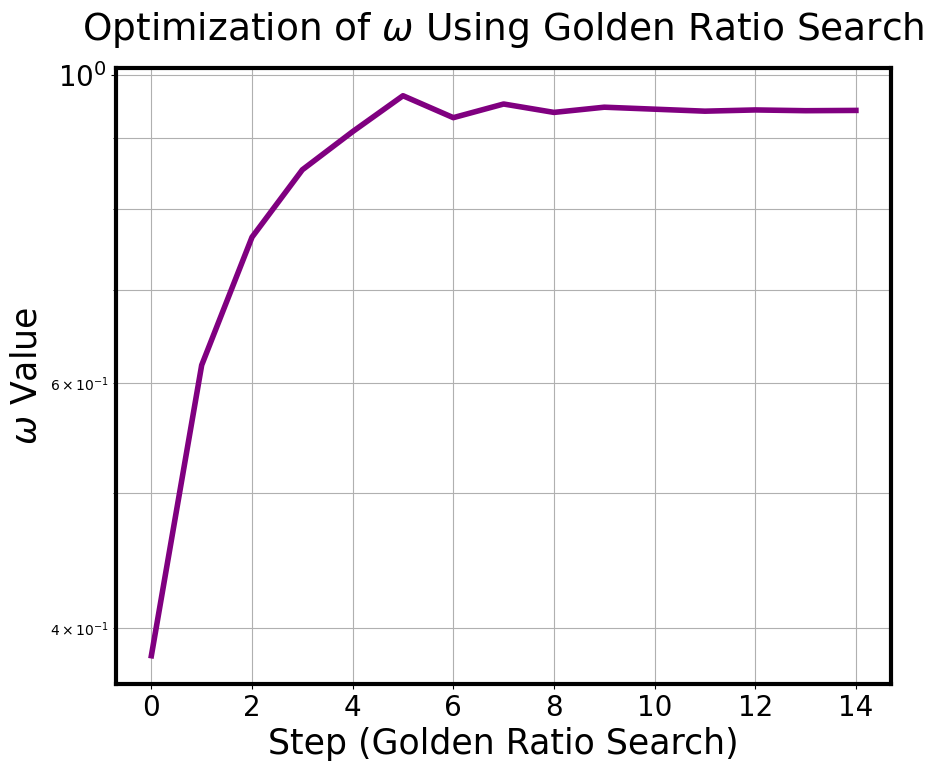

In [40]:
plt.figure(figsize=(10,8),dpi=100)
plt.semilogy(n_iter_array,lw=4,color='purple')
plt.xlabel(r'Step (Golden Ratio Search)',fontsize=25)
plt.ylabel(r'Number of Iterations (Gauss Seidel)',fontsize=25)
plt.title(r'Optimization of $\omega$ Using Golden Ratio Search',fontsize=27,pad='20')
plt.grid(True,which='both')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(labelbottom=True)
plt.tick_params(labelleft=True)
plt.savefig(f'./hw5_p2_n_iter_vs_step',bbox_inches="tight")
plt.show()

plt.figure(figsize=(10,8),dpi=100)
plt.semilogy(omega_array,lw=4,color='purple')
plt.xlabel(r'Step (Golden Ratio Search)',fontsize=25)
plt.ylabel(r'$\omega$ Value',fontsize=25)
plt.title(r'Optimization of $\omega$ Using Golden Ratio Search',fontsize=27,pad='20')
plt.grid(True,which='both')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(labelbottom=True)
plt.tick_params(labelleft=True)
plt.savefig(f'./hw5_p2_omega_vs_step',bbox_inches="tight")
plt.show()